# Feedforward Network with Credit Card Default

Let us look at a BigDL example with Credit Card Default.  We will train a simple, feedforward neural network with 

In [1]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt


from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *
from bigdl.models.ml_pipeline.dl_classifier import *


from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, udf
from pyspark.ml import  Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator




init_engine()

In [2]:
learning_rate = 0.01
training_epochs = 60
batch_size = 1024
display_step = 1

# Network Parameters
n_input = 5
n_classes = 2
n_hidden_1 = 3 # 1st layer number of features
n_hidden_2 = 2 # 1st layer number of features



filename =  "../data/cc-default/default-simple.csv"

LABELS = ["Good", "Default"] 

In [3]:
# Number of hidden layers

n_hidden_guess = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
print("Hidden layer 1 (Guess) : " + str(n_hidden_guess))

n_hidden_guess_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
print("Hidden layer 2 (Guess) : " + str(n_hidden_guess_2))

Hidden layer 1 (Guess) : 2.59002006411
Hidden layer 2 (Guess) : 2.2360679775


In [4]:
cc_training = spark.read.csv(filename, header=True, inferSchema="true", mode="DROPMALFORMED")

In [5]:
df = pd.read_csv(filename)

In [6]:
cc_training.show()

+---+-------+---+---------+--------+---+-------+
| id|balance|sex|education|marriage|age|default|
+---+-------+---+---------+--------+---+-------+
|  1|  20000|  2|        2|       1| 24|      2|
|  2| 120000|  2|        2|       2| 26|      2|
|  3|  90000|  2|        2|       2| 34|      1|
|  4|  50000|  2|        2|       1| 37|      1|
|  5|  50000|  1|        2|       1| 57|      1|
|  6|  50000|  1|        1|       2| 37|      1|
|  7| 500000|  1|        1|       2| 29|      1|
|  8| 100000|  2|        2|       2| 23|      1|
|  9| 140000|  2|        3|       1| 28|      1|
| 10|  20000|  1|        3|       2| 35|      1|
| 11| 200000|  2|        3|       2| 34|      1|
| 12| 260000|  2|        1|       2| 51|      1|
| 13| 630000|  2|        2|       2| 41|      1|
| 14|  70000|  1|        2|       2| 30|      2|
| 15| 250000|  1|        1|       2| 29|      1|
| 16|  50000|  2|        3|       3| 23|      1|
| 17|  20000|  1|        1|       2| 24|      2|
| 18| 320000|  1|   

In [7]:
cc_training.select('balance','sex','education','marriage','age','default').describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|           balance|               sex|         education|          marriage|              age|           default|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|             30000|             30000|             30000|             30000|            30000|             30000|
|   mean|167484.32266666667|1.6037333333333332|1.8531333333333333|1.5518666666666667|          35.4855|            1.2212|
| stddev|129747.66156720246|0.4891291960902602|0.7903486597207269|0.5219696006132467|9.217904068090155|0.4150618056909329|
|    min|             10000|                 1|                 0|                 0|               21|                 1|
|    max|           1000000|                 2|                 6|                 3|               79|                 2|
+-------+-------

In [8]:
cc_training = cc_training.select([col(c).cast("double") for c in cc_training.columns])



In [9]:
cc_training.show()

+----+--------+---+---------+--------+----+-------+
|  id| balance|sex|education|marriage| age|default|
+----+--------+---+---------+--------+----+-------+
| 1.0| 20000.0|2.0|      2.0|     1.0|24.0|    2.0|
| 2.0|120000.0|2.0|      2.0|     2.0|26.0|    2.0|
| 3.0| 90000.0|2.0|      2.0|     2.0|34.0|    1.0|
| 4.0| 50000.0|2.0|      2.0|     1.0|37.0|    1.0|
| 5.0| 50000.0|1.0|      2.0|     1.0|57.0|    1.0|
| 6.0| 50000.0|1.0|      1.0|     2.0|37.0|    1.0|
| 7.0|500000.0|1.0|      1.0|     2.0|29.0|    1.0|
| 8.0|100000.0|2.0|      2.0|     2.0|23.0|    1.0|
| 9.0|140000.0|2.0|      3.0|     1.0|28.0|    1.0|
|10.0| 20000.0|1.0|      3.0|     2.0|35.0|    1.0|
|11.0|200000.0|2.0|      3.0|     2.0|34.0|    1.0|
|12.0|260000.0|2.0|      1.0|     2.0|51.0|    1.0|
|13.0|630000.0|2.0|      2.0|     2.0|41.0|    1.0|
|14.0| 70000.0|1.0|      2.0|     2.0|30.0|    2.0|
|15.0|250000.0|1.0|      1.0|     2.0|29.0|    1.0|
|16.0| 50000.0|2.0|      3.0|     3.0|23.0|    1.0|
|17.0| 20000

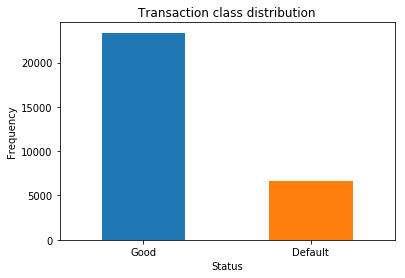

In [10]:
#count_classes = pd.value_counts(df['Class'], sort = True)
count_classes = pd.value_counts(cc_training.select('default').toPandas()['default'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Status")
plt.ylabel("Frequency");

In [11]:
(trainingData, validData) = cc_training.select('balance','sex','education','marriage','age','default').randomSplit([.7,.3])

In [12]:
trainingData.groupBy('balance').count().sort('count', ascending=False ).show(40)

+--------+-----+
| balance|count|
+--------+-----+
| 50000.0| 2334|
| 20000.0| 1386|
| 30000.0| 1118|
| 80000.0| 1093|
|200000.0| 1060|
|150000.0|  789|
|100000.0|  734|
|180000.0|  679|
|360000.0|  620|
| 60000.0|  590|
|230000.0|  543|
|140000.0|  522|
|130000.0|  514|
|500000.0|  508|
|210000.0|  502|
|120000.0|  497|
| 70000.0|  488|
|160000.0|  471|
| 90000.0|  446|
|240000.0|  427|
|110000.0|  419|
|170000.0|  384|
|300000.0|  384|
|280000.0|  356|
| 10000.0|  355|
|260000.0|  351|
|220000.0|  316|
|250000.0|  254|
|290000.0|  245|
|320000.0|  213|
|400000.0|  199|
|310000.0|  192|
|350000.0|  167|
|190000.0|  166|
|270000.0|  161|
|340000.0|  154|
| 40000.0|  149|
|420000.0|  119|
|330000.0|  117|
|390000.0|  117|
+--------+-----+
only showing top 40 rows



In [13]:
assembler =  VectorAssembler(inputCols=['balance','sex','education','marriage','age'], outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")
pipeline = Pipeline(stages = [assembler, scaler])
pipelineTraining = pipeline.fit(trainingData)
cc_data_training = pipelineTraining.transform(trainingData)
pipelineTest = pipeline.fit(validData)
cc_data_test = pipelineTest.transform(validData)

In [14]:
cc_data_training.select('features').rdd.map(lambda x: x[0]).map(lambda x: np.array(x)).take(2)

[array([ 0.07714453,  2.04395644,  1.26342173,  1.91339646,  4.12035441]),
 array([ 0.07714453,  2.04395644,  1.26342173,  1.91339646,  4.33721517])]

In [15]:
#convert ndarray data into RDD[Sample]

# balance,sex,education,marriage,age,default

def array2rdd(ds):
    #build Sample from ndarrays
    def build_sample(balance,sex,education,marriage,age,default):
        feature = np.array([balance,sex,education,marriage,age]).flatten()
        label = np.array(default)
        return Sample.from_ndarray(feature, label)
    rdd = ds.map(lambda (balance,sex,education,marriage,age,default): build_sample(balance,sex,education,marriage,age,default))
    return rdd


def DF2rdd(ds):
    #build Sample from ndarrays
    def build_sample(features, label):
        feature = np.array([balance,sex,education,marriage,age]).flatten()
        label = np.array(default)
        return Sample.from_ndarray(feature, label)
    features = ds.select('features').rdd.map(lambda x: x[0]).map(lambda x: np.array(x)).take(2)
    rdd = ds.map(lambda (balance,sex,education,marriage,age,default): build_sample(balance,sex,education,marriage,age,default))
    return rdd

cc_rdd_train = array2rdd(trainingData.rdd.map(list))
cc_rdd_train.cache()
cc_rdd_train.count()



cc_rdd_test = array2rdd(validData.rdd.map(list))
cc_rdd_test.cache()
cc_rdd_test.count()


9073

In [16]:
validData.take(20)

[Row(balance=10000.0, sex=1.0, education=1.0, marriage=1.0, age=41.0, default=1.0),
 Row(balance=10000.0, sex=1.0, education=1.0, marriage=1.0, age=48.0, default=1.0),
 Row(balance=10000.0, sex=1.0, education=1.0, marriage=2.0, age=23.0, default=2.0),
 Row(balance=10000.0, sex=1.0, education=1.0, marriage=2.0, age=23.0, default=2.0),
 Row(balance=10000.0, sex=1.0, education=1.0, marriage=2.0, age=24.0, default=1.0),
 Row(balance=10000.0, sex=1.0, education=1.0, marriage=2.0, age=24.0, default=2.0),
 Row(balance=10000.0, sex=1.0, education=1.0, marriage=2.0, age=24.0, default=2.0),
 Row(balance=10000.0, sex=1.0, education=1.0, marriage=2.0, age=26.0, default=1.0),
 Row(balance=10000.0, sex=1.0, education=1.0, marriage=2.0, age=26.0, default=2.0),
 Row(balance=10000.0, sex=1.0, education=1.0, marriage=2.0, age=33.0, default=1.0),
 Row(balance=10000.0, sex=1.0, education=2.0, marriage=1.0, age=27.0, default=1.0),
 Row(balance=10000.0, sex=1.0, education=2.0, marriage=1.0, age=28.0, defaul

In [17]:
cc_rdd_train.take(3)

[Sample: features: [JTensor: storage: [  1.00000000e+04   1.00000000e+00   1.00000000e+00   1.00000000e+00
    3.80000000e+01], shape: [5], float], label: JTensor: storage: [ 2.], shape: [1], float,
 Sample: features: [JTensor: storage: [  1.00000000e+04   1.00000000e+00   1.00000000e+00   1.00000000e+00
    4.00000000e+01], shape: [5], float], label: JTensor: storage: [ 2.], shape: [1], float,
 Sample: features: [JTensor: storage: [  1.00000000e+04   1.00000000e+00   1.00000000e+00   1.00000000e+00
    4.20000000e+01], shape: [5], float], label: JTensor: storage: [ 1.], shape: [1], float]

In [18]:
# Create model

def multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes):
    # Initialize a sequential container
    model = Sequential()
    # Hidden layer with ReLu activation
    model.add(Linear(n_input, n_hidden_1).set_name('mlp_fc1'))
    model.add(Dropout(0.2))
    model.add(ReLU())
    # Hidden layer with ReLu activation
    #model.add(Linear(n_hidden_1, n_hidden_2).set_name('mlp_fc2'))
    #model.add(ReLU())
    # output layer
    #model.add(Linear(n_hidden_2, n_classes).set_name('mlp_fc3'))
    model.add(Linear(n_hidden_1, n_classes).set_name('mlp_fc3'))
    model.add(LogSoftMax())
    return model

model = multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes)

creating: createSequential
creating: createLinear
creating: createDropout
creating: createReLU
creating: createLinear
creating: createLogSoftMax


In [19]:
# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=cc_rdd_train,
    criterion=ClassNLLCriterion(),
    optim_method=Adagrad(learningrate=learning_rate, learningrate_decay=0.0002),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=cc_rdd_test,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='cc-default-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createAdagrad
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
('saving logs to ', 'cc-default-20171115-183958')


In [20]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 50 ms, sys: 10 ms, total: 60 ms
Wall time: 1min 8s


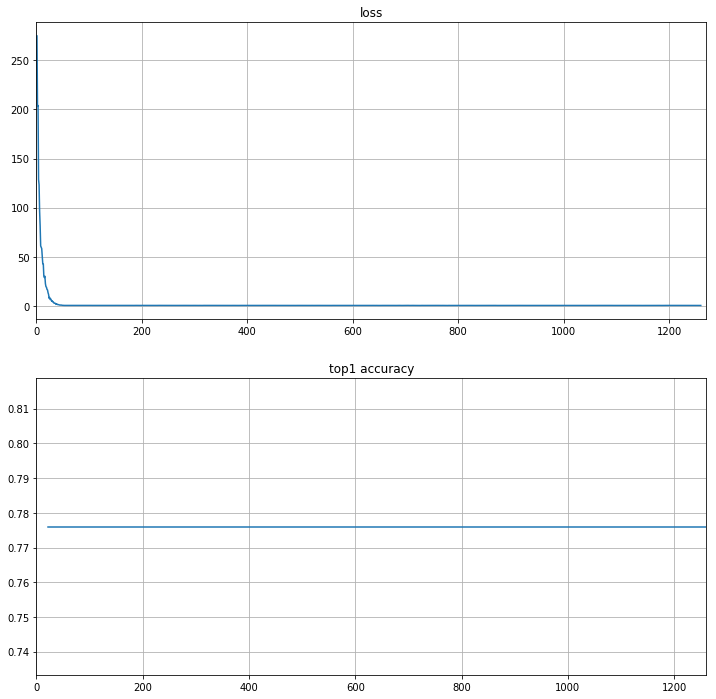

In [21]:

loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0])
plt.title("top1 accuracy")
plt.grid(True)

In [22]:
predictions = trained_model.predict(cc_rdd_test).collect()

def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l.to_ndarray()[0] - 1

y_pred = np.array([ map_predict_label(s) for s in predictions])

y_true = np.array([map_groundtruth_label(s.label) for s in cc_rdd_test.collect()])

In [23]:
print(str(np.abs(predictions[0])))
print(str(y_true[0]))
map_predict_label(predictions[0])


[ 0.40660739  1.09633136]
0.0


0

The prediction accuracy is 77.60%


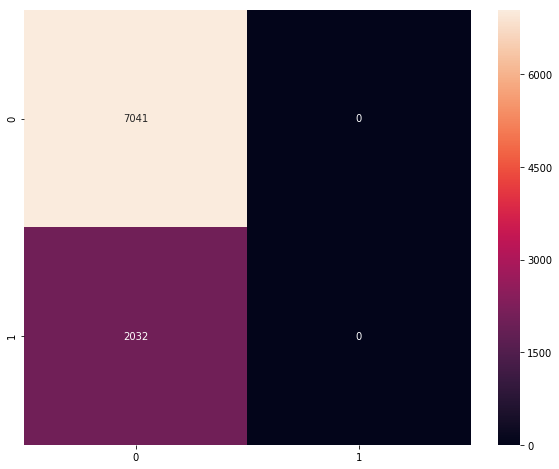

In [24]:
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');